# USDA Food Nutrient Classifier

## Introduction

## Notebook setup

In [ ]:
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd
import copy

## Dataset

src: USDA

## Import dataset

In [ ]:
file_path = os.path.join('..', 'foundationFoods.json') # Path relative to notebook

with open(file_path, 'r') as f:
    foundation_data = json.load(f)
df_foundation = pd.DataFrame(foundation_data)

## Standardize units

Foundation foods:
sample weight -> scale to 100g
s
Branded foods:
serving size in grams -> scale to serving of 100g

scale everything to g of nutrient per 100g of food

In [24]:
def standardize_nutrient_units(food_nutrients_list):
    """
    Standardizes nutrient amounts to grams (G) within a list of nutrient dictionaries.
    Amounts are assumed to be per 100g of food already.
    """
    if not isinstance(food_nutrients_list, list):
        return None 
        
    standardized_nutrients = []
    for nutrient in food_nutrients_list:
        nutrient_copy = copy.deepcopy(nutrient)
        original_amount = nutrient_copy.get('amount')
        unit_name = str(nutrient_copy.get('unitName', '')).upper()

        if original_amount is None:
            standardized_nutrients.append(nutrient_copy)
            continue

        new_amount = original_amount
        if unit_name == 'MG':
            new_amount = original_amount / 1000.0
        elif unit_name in ['UG', 'ΜG', 'MCG']: # Handling 'µg' (often as UG or MCG)
            new_amount = original_amount / 1_000_000.0
        elif unit_name == 'G':
            pass 
        else:
            pass 

        nutrient_copy['amount'] = new_amount
        nutrient_copy['unitName'] = 'G' 
        standardized_nutrients.append(nutrient_copy)
        
    return standardized_nutrients
    

if 'foodNutrients' in df_foundation.columns and not df_foundation.empty:
    df_foundation['foodNutrients_standardized'] = df_foundation['foodNutrients'].apply(standardize_nutrient_units)
    
    print("Applied nutrient unit standardization. New column 'foodNutrients_standardized' created.")
    
    print("\n--- Sample of original foodNutrients (first food item, first 2 nutrients if available) ---")
    original_nutrients_sample = df_foundation.iloc[0]['foodNutrients']
    if original_nutrients_sample and isinstance(original_nutrients_sample, list) and len(original_nutrients_sample) > 0:
        for i, nutrient in enumerate(original_nutrients_sample[:2]):
            print(f"Nutrient {i+1}: Name='{nutrient.get('name')}', Amount={nutrient.get('amount')}, Unit='{nutrient.get('unitName')}'")
    else:
        print("No original nutrient data to display for the first food item or it's not in the expected list format.")

    print("\n--- Sample of standardized foodNutrients_standardized (first food item, first 2 nutrients if available) ---")
    standardized_nutrients_sample = df_foundation.iloc[0]['foodNutrients_standardized']
    if standardized_nutrients_sample and isinstance(standardized_nutrients_sample, list) and len(standardized_nutrients_sample) > 0:
        for i, nutrient in enumerate(standardized_nutrients_sample[:2]):
            print(f"Nutrient {i+1}: Name='{nutrient.get('name')}', Amount={nutrient.get('amount')}, Unit='{nutrient.get('unitName')}'")
    else:
        print("No standardized nutrient data to display for the first food item or it's not in the expected list format.")
else:
    print("Error: 'foodNutrients' column not found in DataFrame or DataFrame is empty. Cannot standardize.")

Applied nutrient unit standardization. New column 'foodNutrients_standardized' created.

--- Sample of original foodNutrients (first food item, first 2 nutrients if available) ---
Nutrient 1: Name='Cryptoxanthin, beta', Amount=3.0, Unit='µg'
Nutrient 2: Name='Lycopene', Amount=0.0, Unit='µg'

--- Sample of standardized foodNutrients_standardized (first food item, first 2 nutrients if available) ---
Nutrient 1: Name='Cryptoxanthin, beta', Amount=3e-06, Unit='G'
Nutrient 2: Name='Lycopene', Amount=0.0, Unit='G'


## Removing sweet

In [38]:
min_samples = 2  
value_counts = df_foundation['foodClass'].value_counts()
classes_to_remove = value_counts[value_counts < min_samples].index.tolist()

if classes_to_remove:
    print(f"Removing classes with fewer than {min_samples} samples: {classes_to_remove}")
    df_foundation_filtered = df_foundation[~df_foundation['foodClass'].isin(classes_to_remove)].copy() # Use .copy() to avoid SettingWithCopyWarning
    
    print(f"Original DataFrame shape: {df_foundation.shape}")
    print(f"Filtered DataFrame shape: {df_foundation_filtered.shape}")
    print("\n--- Value Counts of foodClass (Categories) AFTER filtering ---")
    print(df_foundation_filtered['foodClass'].value_counts())
else:
    print(f"No classes found with fewer than {min_samples} samples. No filtering needed based on this criterion.")
    

Removing classes with fewer than 2 samples: ['Sweets']
Original DataFrame shape: (340, 4)
Filtered DataFrame shape: (339, 4)

--- Value Counts of foodClass (Categories) AFTER filtering ---
foodClass
Vegetables and Vegetable Products    78
Fruits and Fruit Juices              48
Dairy and Egg Products               42
Cereal Grains and Pasta              41
Legumes and Legume Products          37
Nut and Seed Products                19
Beef Products                        15
Poultry Products                     11
Finfish and Shellfish Products       10
Fats and Oils                         9
Pork Products                         7
Sausages and Luncheon Meats           6
Restaurant Foods                      4
Baked Products                        3
Beverages                             3
Spices and Herbs                      2
Soups, Sauces, and Gravies            2
Lamb, Veal, and Game Products         2
Name: count, dtype: int64


In [ ]:
def get_product_names(category):
    """
    Extracts and returns a list of product names from a list of a given category.
    """
    print("Foods in Beverages category:")
    beverages = df_foundation[df_foundation['foodClass'] == category]
    if not beverages.empty:
        for i, food in enumerate(beverages['description']):
            print(f"{i+1}: {food}")
    else:
        print("No foods found in the Beverages category.")

def get_nutrient_names(category):
    """
    Extracts and returns a list of nutrient names from a list of nutrient dictionaries.
    """

    print("\nNutrients in Beverages category:")
    beverages = df_foundation[df_foundation['foodClass'] == category]
    beverages_nutrients = beverages['foodNutrients'].tolist()
    #print(beverages_nutrients)
    if beverages_nutrients:
        for i, food in enumerate(beverages_nutrients):
            for j, nutrient in enumerate(food):
                if (nutrient.get('amount' ) != 0.0):
                    print(f"Food {i+1}: Name='{nutrient.get('name')}', Amount={nutrient.get('amount')}, Unit='{nutrient.get('unitName')}'")
            print("\n")
    else:
        print("No nutrients found for the Beverages category or no beverages available.")
    
# Example usage
get_product_names('Beverages')
get_nutrient_names('Beverages')

Foods in Beverages category:
1: Almond milk, unsweetened, plain, shelf stable
2: Almond milk, unsweetened, plain, refrigerated
3: Oat milk, unsweetened, plain, refrigerated

Nutrients in Beverages category:
Food 1: Name='Fatty acids, total monounsaturated', Amount=0.729, Unit='g'
Food 1: Name='Fatty acids, total polyunsaturated', Amount=0.276, Unit='g'
Food 1: Name='SFA 15:0', Amount=0.001, Unit='g'
Food 1: Name='SFA 17:0', Amount=0.001, Unit='g'
Food 1: Name='Water', Amount=97.4, Unit='g'
Food 1: Name='MUFA 16:1 c', Amount=0.006, Unit='g'
Food 1: Name='MUFA 18:1 c', Amount=0.721, Unit='g'
Food 1: Name='PUFA 18:2 n-6 c,c', Amount=0.276, Unit='g'
Food 1: Name='MUFA 17:1', Amount=0.001, Unit='g'
Food 1: Name='Raffinose', Amount=0.008, Unit='g'
Food 1: Name='Stachyose', Amount=0.007, Unit='g'
Food 1: Name='Calcium, Ca', Amount=173, Unit='mg'
Food 1: Name='Iron, Fe', Amount=0.29, Unit='mg'
Food 1: Name='Magnesium, Mg', Amount=6.78, Unit='mg'
Food 1: Name='Phosphorus, P', Amount=29.8, Unit=

## Feature prepairation

In [9]:
#Create a list of dictionaries, where each dictionary maps nutrient names to amounts for a single food
all_foods_nutrient_data_for_df = []

for index, row in df_foundation.iterrows():
    nutrients_for_this_food = {}
  
    if isinstance(row['foodNutrients_standardized'], list):
        for nutrient_info in row['foodNutrients_standardized']:
            # Check if nutrient_info is a dictionary and has the required keys
            if isinstance(nutrient_info, dict) and 'name' in nutrient_info and 'amount' in nutrient_info:
                nutrient_name = str(nutrient_info['name']).strip() # Use cleaned nutrient name as key
                amount = nutrient_info['amount']

                nutrients_for_this_food[nutrient_name] = amount

    all_foods_nutrient_data_for_df.append(nutrients_for_this_food)

# Create a DataFrame from this list of dictionaries

nutrient_features_df = pd.DataFrame(all_foods_nutrient_data_for_df, index=df_foundation.index)

#Fill NaN values with 0
nutrient_features_df = nutrient_features_df.fillna(0)

# Defines our feature matrix X and target vector y
X = nutrient_features_df
y = df_foundation['foodClass']

# Displays some information about the created feature matrix and target vector
print("--- Nutrient Features DataFrame (X) ---")
print(f"Shape of X (features): {X.shape}")
print(X.head())

print("\n--- Target Vector (y) ---")
print(f"Shape of y (target classes): {y.shape}")
print(y.head())
print("\nValue counts for y (target classes):")
print(y.value_counts().head()) # Show top few classes

# Verifys no NaN values are left in X
print(f"\nTotal NaN values in X after fillna(0): {X.isnull().sum().sum()}")

# Checks consistency of number of samples
if X.shape[0] == y.shape[0]:
    print(f"\nNumber of samples in X ({X.shape[0]}) matches y ({y.shape[0]}). Ready for train-test split.")
else:
    print(f"\nWarning: Mismatch in number of samples! X has {X.shape[0]}, y has {y.shape[0]}.")


--- Nutrient Features DataFrame (X) ---
Shape of X (features): (339, 227)
   Cryptoxanthin, beta  Lycopene  Tocopherol, delta  Tocotrienol, gamma  \
0             0.000003    0.0000            0.00130                 0.0   
1             0.000000    0.0041            0.00012                 0.0   
2             0.000000    0.0000            0.00000                 0.0   
3             0.000000    0.0000            0.00000                 0.0   
4             0.000009    0.0000            0.00000                 0.0   

   Tocotrienol, delta  Vitamin C, total ascorbic acid   Thiamin  Riboflavin  \
0                 0.0                          0.0000  0.000150    0.000115   
1                 0.0                          0.0272  0.000075    0.000065   
2                 0.0                          0.0000  0.000000    0.000000   
3                 0.0                          0.0000  0.000033    0.000154   
4                 0.0                          0.0000  0.000079    0.001570   



## Train Test Split

In [ ]:
# Check if X and y are defined and not empty
if 'X' in locals() and hasattr(X, 'empty') and not X.empty and \
   'y' in locals() and hasattr(y, 'empty') and not y.empty:
    
    print("--- Splitting Data into Training and Testing Sets ---")
    # Split the data into training (80%) and testing (20%) sets

    # random_state ensures reproducibility of the split
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.20, 
        random_state=42, 
        stratify=y
    )

    print("\n--- Data Split Complete ---")
    print(f"Shape of X_train (training features): {X_train.shape}")
    print(f"Shape of X_test (testing features):  {X_test.shape}")
    print(f"Shape of y_train (training labels): {y_train.shape}")
    print(f"Shape of y_test (testing labels):  {y_test.shape}")

    print("\n--- Training Set Class Distribution (y_train) ---")
    print(y_train.value_counts(normalize=True).head()) # Percentage distribution for top classes

    print("\n--- Testing Set Class Distribution (y_test) ---")
    print(y_test.value_counts(normalize=True).head()) # Percentage distribution for top classes
    
else:
    print("Error: X or y is not defined or is empty. Please ensure the Feature Preparation cell was run successfully and X, y variables are available.")


--- Splitting Data into Training and Testing Sets ---

--- Data Split Complete ---
Shape of X_train (training features): (271, 227)
Shape of X_test (testing features):  (68, 227)
Shape of y_train (training labels): (271,)
Shape of y_test (testing labels):  (68,)

--- Training Set Class Distribution (y_train) ---
foodClass
Vegetables and Vegetable Products    0.228782
Fruits and Fruit Juices              0.140221
Dairy and Egg Products               0.121771
Cereal Grains and Pasta              0.121771
Legumes and Legume Products          0.110701
Name: proportion, dtype: float64

--- Testing Set Class Distribution (y_test) ---
foodClass
Vegetables and Vegetable Products    0.235294
Fruits and Fruit Juices              0.147059
Dairy and Egg Products               0.132353
Cereal Grains and Pasta              0.117647
Legumes and Legume Products          0.102941
Name: proportion, dtype: float64


## Category mapping

foundation foods 28 cats
branded foods ~350 cats

current ./src/mapping.py done with GPT-4.1, needs manual review.

## Training classifier

--- Training the RandomForestClassifier ---
Model training complete.

--- Evaluating Model Performance on the Test Set ---
Accuracy: 0.8824

Classification Report:
                                   precision    recall  f1-score   support

                   Baked Products       1.00      1.00      1.00         1
                    Beef Products       1.00      1.00      1.00         3
                        Beverages       0.00      0.00      0.00         1
          Cereal Grains and Pasta       1.00      1.00      1.00         8
           Dairy and Egg Products       0.82      1.00      0.90         9
                    Fats and Oils       1.00      0.50      0.67         2
   Finfish and Shellfish Products       1.00      1.00      1.00         2
          Fruits and Fruit Juices       0.88      0.70      0.78        10
      Legumes and Legume Products       1.00      1.00      1.00         7
            Nut and Seed Products       1.00      1.00      1.00         4
          

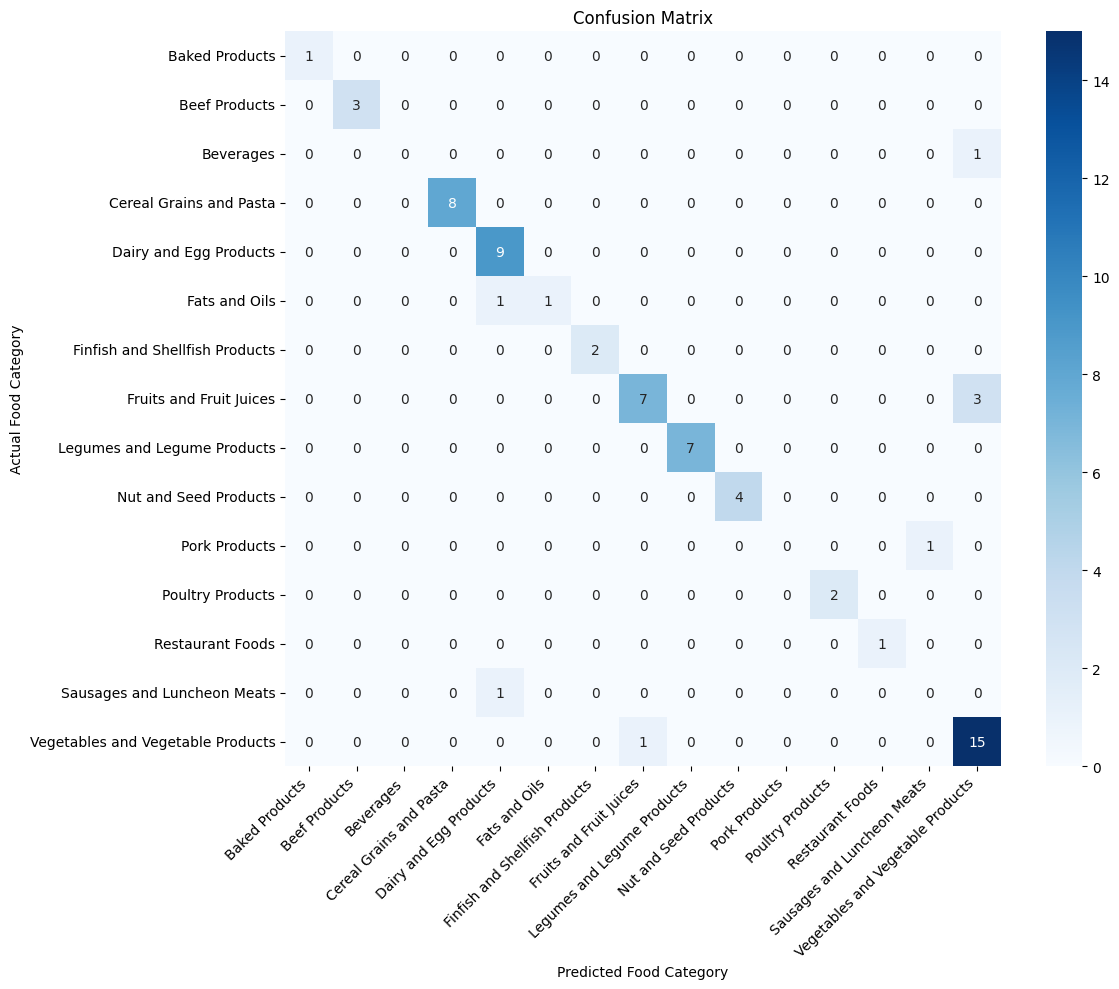

In [ ]:
# Checks if training data is available
if 'X_train' in locals() and 'y_train' in locals() and not X_train.empty and not y_train.empty:
    print("--- Training the RandomForestClassifier ---")
    
    # Initialize the RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    
    # Train the model
    model.fit(X_train, y_train)
    
    print("Model training complete.")
    
    # Evaluating the Model
    print("\n--- Evaluating Model Performance on the Test Set ---")
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Generate a classification report
    print("\nClassification Report:")
    # Get all unique labels that are present in either y_test or y_pred for the report

    report_labels = np.union1d(y_test.unique(), y_pred) 
    print(classification_report(y_test, y_pred, labels=report_labels, zero_division=0))
    
    # Generates and display the confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=report_labels)
    
    # Plotting the confusion matrix for better visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=report_labels, yticklabels=report_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Food Category')
    plt.xlabel('Predicted Food Category')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Error: Training data (X_train, y_train) not found. Please ensure the train-test split cell was run successfully.")